**Full Name:** Athanasios Chouklis

**SRN:** 10396

**Email:** cathanasd@ece.auth.gr


Department of Electrical and Computer Engineering, Aristotle University of Thessaloniki

## **Third Assignment in Neural Networks - Deep Learning**

So far we have used **Nearest Neighbor**, **Nearest Centroid**, **MLP**, **CNN** and **SVM** classifiers for image classification on the **CIFAR-10** database.

In this final assignment we will test the performance of an **RBF** (Radial Basis Function) neural network on the same database.

RBF networks are 3-layer neural networks with the following configuration:

- Input Layer
- Hidden Layer
- Output Layer

where the hidden layer utilizes a non-linear Radial Basis Function and the output layer is a simple linear layer. Each unit in the hidden layer (ie each RBF neuron) produces an output based on (typically) the Euclidean distance of the input vector to its **center** vector. The radial basis function is most often taken to be Gaussian.

Like before, PyTorch is preferred due to GPU acceleration.

To start, we import the libraries we'll be using.

In [196]:
# PyTorch tools are imported for the purpose of comparison with an MLP

# Import PyTorch
import torch
from torch import nn

# Import PyTorch DataLoader and Learning Rate Scheduler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ExponentialLR

# Import torchvision data manipulation tools
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import PCA for PyTorch
from torch_pca import PCA as torchPCA

#Import the torchmetrics MulticlassAccuracy function
from torchmetrics.classification import MulticlassAccuracy


# Import scikit-learn tools

# KMeans Algorithm for defining RBF neuron centers by clustering
from sklearn.cluster import KMeans

# Import numpy
import numpy as np

# Import matplotlib and pandas for data visualization
import matplotlib.pyplot as plt
import pandas as pd

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Import timer to time our models
from timeit import default_timer as timer

# Import Dict and List for metrics plotting
from typing import Dict, List

# Import random for the creation of a random sample of images
import random

Then we load the data with the same method we used previously.

In [118]:
# Setup device agnostic code; we want to use GPU acceleration if available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Check to see if GPU acceleration is available
print(device)

# Set a random seed for reproducibility
torch.manual_seed(36)
torch.cuda.manual_seed(36)

# Setup training data
tensor_train_data = datasets.CIFAR10(
    root="data", # data download location
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, which we will turn into Torch tensors
    target_transform=None # option to transform labels as well
)

# Setup testing data
tensor_test_data = datasets.CIFAR10(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(tensor_train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # number of samples per batch
    shuffle=True # option to shuffle data every epoch
)

test_dataloader = DataLoader(tensor_test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

class_names = tensor_train_data.classes

cuda
Files already downloaded and verified
Files already downloaded and verified


We will also create a DataLoader with batch size equal to the training data size. This will be useful for applying PCA, among other things.

In [119]:
# We will need the whole dataset in order to apply PCA to it, so we will use the DataLoader with a batch size equal to the number of samples in the dataset to make a 'bulk' dataloader for this purpose

# Turn datasets into iterables (batches)
bulk_train_loader = DataLoader(tensor_train_data, # dataset to turn into iterable
    batch_size=50000, # number of samples per batch
    shuffle=False # option to shuffle data every epoch
)

bulk_test_loader = DataLoader(tensor_test_data,
    batch_size=10000,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Retrieve all training and testing data
bulk_tensor_train_data, bulk_tensor_train_labels = next(iter(bulk_train_loader))
bulk_tensor_test_data, bulk_tensor_test_labels = next(iter(bulk_test_loader))

# Flatten images (N, C, H, W) -> (N, C*H*W)
bulk_tensor_train_data = bulk_tensor_train_data.view(bulk_tensor_train_data.size(0), -1)
bulk_tensor_test_data = bulk_tensor_test_data.view(bulk_tensor_test_data.size(0), -1)

# Verify dimensions
print(bulk_tensor_train_data.shape) 

torch.Size([50000, 3072])


The training, testing and plotting functions are carried over from the previous assignments. The same goes for the function that combines them all into one.

**Training function**

In [120]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               scheduler: torch.optim.lr_scheduler._LRScheduler,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred, y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward (backpropagation)
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    if scheduler is not None:
        scheduler.step()

    # Calculate loss and accuracy per epoch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    # Return metrics
    return train_loss, train_acc

**Testing function**

In [121]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(test_pred,y)
        
        # Calculate loss and accuracy per epoch
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        # Return metrics
        return test_loss, test_acc

**Results plotting function**

In [122]:
def plot_metrics_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss_values = results['train_loss']
    test_loss_values = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    acc_values = results['train_acc']
    test_acc_values = results['test_acc']

    # Figure out how many epochs there were
    num_of_epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(num_of_epochs, loss_values, label='train_loss')
    plt.plot(num_of_epochs, test_loss_values, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(num_of_epochs, acc_values, label='train_accuracy')
    plt.plot(num_of_epochs, test_acc_values, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

**Combination of above three**

In [123]:
def test_train_plot(model: torch.nn.Module,
               data_loader_train: torch.utils.data.DataLoader,
               data_loader_test: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               epochs,
               scheduler: torch.optim.lr_scheduler._LRScheduler):

    # Create a results dictionary to store the metrics
    results = {"train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []
        }

    # Start the timer
    start_time = timer()

    # Training loop
    for epoch in tqdm(range(epochs)):
        # Training step
        train_loss, train_acc = train_step(data_loader=data_loader_train, 
            model=model, 
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            scheduler=scheduler
        )
        
        #Testing step
        test_loss, test_acc = test_step(data_loader=data_loader_test,
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
        )
        
        # Print out the loss and accuracy
        if epochs == 51:
            if epoch % 10 == 0:
                print(f"Epoch: {epoch}\n---------")
                print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc*100:.2f}%")
                print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc*100:.2f}%\n")
        if epochs == 101:
            if epoch % 20 == 0:
                print(f"Epoch: {epoch}\n---------")
                print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc*100:.2f}%")
                print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc*100:.2f}%\n")
        
        # Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage and plotting
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # End the timer and print out how long it took
    end_time = timer()
    print(f"Total training time: {end_time-start_time:.3f} seconds")

    plot_metrics_curves(results)

Next we define the RBF model we'll be using as a PyTorch `class`.

For now, the sigma parameter will not be set as a model parameter and will instead be equal to **max(d)/sqrt(2p)**, where **p** represents the number of neurons in the hidden layer (and thus, the number of centers). The function chosen is the Gauss function.

In [125]:
class RBF(nn.Module):
    def __init__(self, centers: torch.Tensor, output_shape: int):
        super().__init__()

        # The number of hidden units is equal to the number of centers
        self.hidden_units = centers.shape[0]

        # The centers are the main parameters of the model (what the model adjusts when it learns)
        self.centers = nn.Parameter(centers, requires_grad=True)

        # The sigma parameter is set to a value that in theory should work relatively well
        d = torch.cdist(centers, centers)
        # As for why we do this step, see https://github.com/pytorch/pytorch/issues/123082
        d.fill_diagonal_(0)
        sigma = torch.max(d) / ((2 * self.hidden_units)**0.5)

        # For now we do not set sigma as a parameter to be learned
        #self.sigma = nn.Parameter(torch.ones(self.hidden_units, device=device)*sigma, requires_grad=True)
        self.sigma = sigma

        # The output layer is a simple linear layer
        self.output_layer = nn.Linear(in_features=self.hidden_units, out_features=output_shape)
    
    def forward(self, x):
        # Calculate the distance between the input and the centers
        flatten = nn.Flatten()
        dist = torch.cdist(flatten(x), self.centers)
        # Calculate the RBF function
        rbf = torch.exp(-dist**2 / (2 * self.sigma**2))
        # Calculate the output
        return  self.output_layer(rbf)
    

For our first test, we will feed the model centers chosen entirely at random (of course, in the range of our data: [0,1]). If we used only a small number of random centers, there is a possibility that they end up too close together. To avoid this issue, we will create a large number of them, eg 100.

This test is unlikely to yield much success, but this makes it a good starting point, as we can expect to only go up from here.

  1%|          | 1/101 [00:08<14:53,  8.93s/it]

Epoch: 0
---------
Train loss: 2.30336 | Train accuracy: 10.02%
Test loss: 2.30325 | Test accuracy: 10.01%



 21%|██        | 21/101 [03:02<11:38,  8.73s/it]

Epoch: 20
---------
Train loss: 2.30272 | Train accuracy: 9.85%
Test loss: 2.30260 | Test accuracy: 9.99%



 41%|████      | 41/101 [05:56<08:39,  8.65s/it]

Epoch: 40
---------
Train loss: 2.30260 | Train accuracy: 9.39%
Test loss: 2.30258 | Test accuracy: 9.98%



 60%|██████    | 61/101 [08:50<05:45,  8.64s/it]

Epoch: 60
---------
Train loss: 2.30257 | Train accuracy: 9.70%
Test loss: 2.30258 | Test accuracy: 9.98%



 80%|████████  | 81/101 [11:43<02:53,  8.68s/it]

Epoch: 80
---------
Train loss: 2.30256 | Train accuracy: 9.98%
Test loss: 2.30259 | Test accuracy: 9.98%



100%|██████████| 101/101 [14:38<00:00,  8.70s/it]

Epoch: 100
---------
Train loss: 2.30256 | Train accuracy: 10.00%
Test loss: 2.30259 | Test accuracy: 9.98%

Total training time: 878.995 seconds


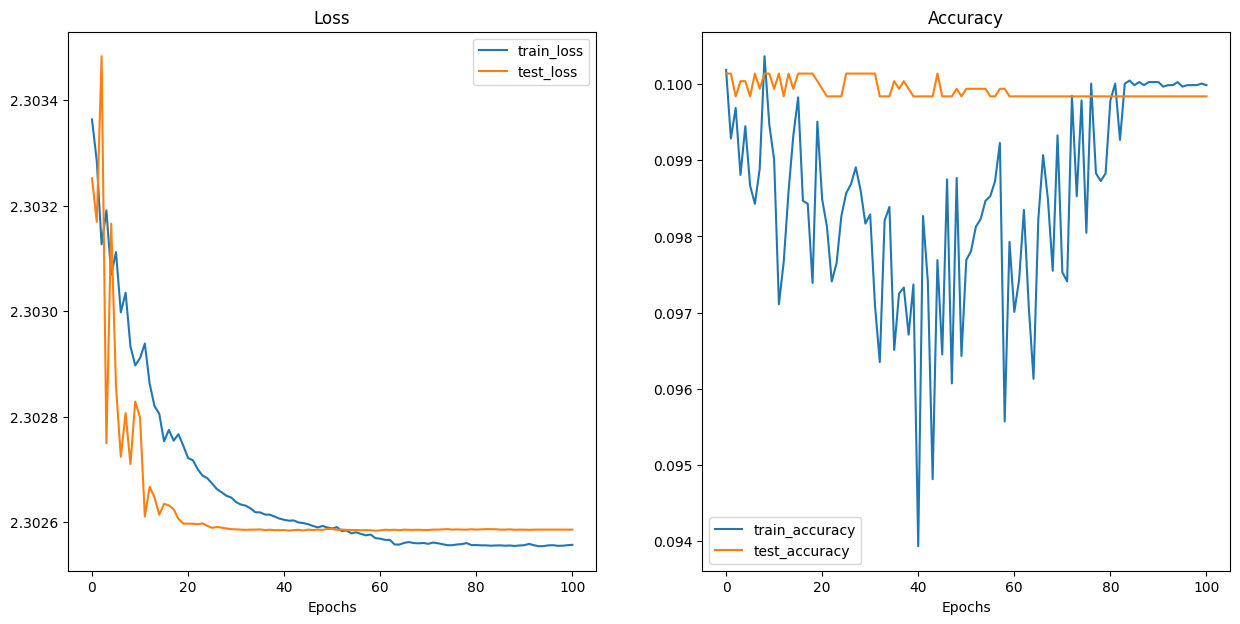

In [139]:
random_centers = torch.rand(100, 3072, device=device)

# Setup model with input parameters
RBF_clf = RBF(centers=random_centers, # number of RBF neurons
    output_shape=len(class_names) # one for every class
).to(device)

# Setup optimizer
optimizer = torch.optim.SGD(params=RBF_clf.parameters(), lr=0.1)

# Setup accuracy function
mca = MulticlassAccuracy(num_classes=10, average='micro').to(device)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup scheduler
scheduler = ExponentialLR(optimizer, gamma=0.9)

# Set number of epochs
epochs = 101

test_train_plot(model=RBF_clf,
               data_loader_train=train_dataloader,
               data_loader_test=test_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=mca,
               epochs=epochs,
               scheduler=scheduler)

The results of our model, even after 101 epochs, are as good as random chance (1 in 10). Interestingly, the testing accuracy remains relatively stable all throughout the run but the training accuracy fluctuates wildly before finally converging at the value of **10%** (chance odds) after around 80 epochs.

In addition, the loss and accuracy curves do not match up at all, especially for the training part; this is because a decrease in cross-entropy loss does not actually necessarily imply an increase in accuracy: a prediction probabiliy that is "more correct" (ie closer to the right answer) but does not pass the desired classification threshold will produce a decrease in loss but no increase in accuracy.

Obviously this approach is very flawed. Let's try this again but this time we'll pick 100 random samples from the training data to be our centers, instead of just randomly generating them.

  1%|          | 1/101 [00:08<14:25,  8.66s/it]

Epoch: 0
---------
Train loss: 2.30359 | Train accuracy: 9.98%
Test loss: 2.30293 | Test accuracy: 9.95%



 21%|██        | 21/101 [03:02<11:36,  8.71s/it]

Epoch: 20
---------
Train loss: 2.30201 | Train accuracy: 11.08%
Test loss: 2.30196 | Test accuracy: 10.53%



 41%|████      | 41/101 [05:55<08:38,  8.63s/it]

Epoch: 40
---------
Train loss: 2.30181 | Train accuracy: 13.91%
Test loss: 2.30184 | Test accuracy: 15.88%



 60%|██████    | 61/101 [08:48<05:50,  8.76s/it]

Epoch: 60
---------
Train loss: 2.30178 | Train accuracy: 15.80%
Test loss: 2.30183 | Test accuracy: 15.38%



 80%|████████  | 81/101 [11:42<02:53,  8.65s/it]

Epoch: 80
---------
Train loss: 2.30177 | Train accuracy: 16.96%
Test loss: 2.30183 | Test accuracy: 17.13%



100%|██████████| 101/101 [14:34<00:00,  8.66s/it]

Epoch: 100
---------
Train loss: 2.30177 | Train accuracy: 17.29%
Test loss: 2.30183 | Test accuracy: 17.26%

Total training time: 874.962 seconds


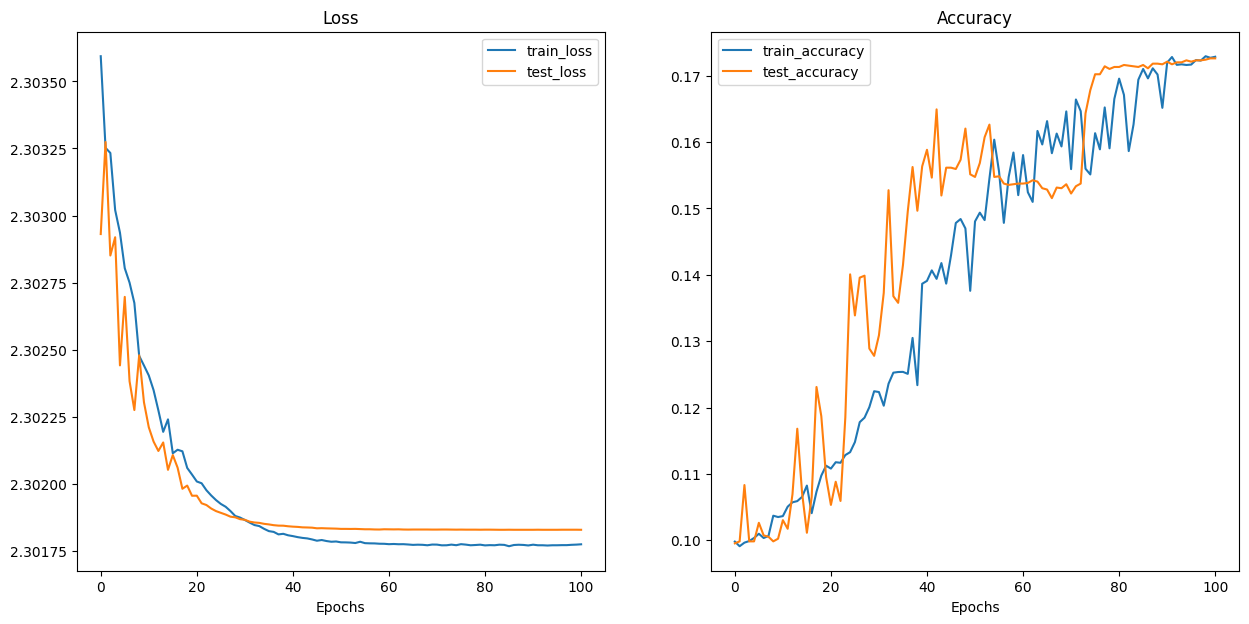

In [136]:
random.seed(36)

# Pick 100 random samples from the training data to be our centers
random_sample_centers = bulk_tensor_train_data[random.sample(range(50000), 100)]

# Setup model with input parameters
RBF_clf = RBF(centers=random_sample_centers, # number of RBF neurons
    output_shape=len(class_names) # one for every class
).to(device)

# Setup optimizer
optimizer = torch.optim.SGD(params=RBF_clf.parameters(), lr=0.1)

# Setup accuracy function
mca = MulticlassAccuracy(num_classes=10, average='micro').to(device)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup scheduler
scheduler = ExponentialLR(optimizer, gamma=0.9)

# Set number of epochs
epochs = 101

test_train_plot(model=RBF_clf,
               data_loader_train=train_dataloader,
               data_loader_test=test_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=mca,
               epochs=epochs,
               scheduler=scheduler)

The performance of the model is still not great, managing a measly **~17%** accuracy after 101 epochs. However it is an improvement to the previous attempt, despite the fact that we retain the two previous flaws: a very unstable accuracy curve (this time both the training and testing one) and an obvious mismatch between the loss and accuracy curves. In spite of this instability, it does actually appear to converge at the end.

Now let's see what the results will be if we set every sample in the training data to be a center.

  2%|▏         | 1/51 [01:25<1:10:51, 85.03s/it]

Epoch: 0
---------
Train loss: 2.30339 | Train accuracy: 9.88%
Test loss: 2.30294 | Test accuracy: 9.98%



 22%|██▏       | 11/51 [15:19<55:41, 83.53s/it] 

Epoch: 10
---------
Train loss: 2.28676 | Train accuracy: 25.62%
Test loss: 2.30277 | Test accuracy: 10.01%



 41%|████      | 21/51 [29:13<41:49, 83.63s/it]

Epoch: 20
---------
Train loss: 2.28104 | Train accuracy: 85.20%
Test loss: 2.30259 | Test accuracy: 10.01%



 61%|██████    | 31/51 [43:17<28:14, 84.74s/it]

Epoch: 30
---------
Train loss: 2.27900 | Train accuracy: 99.86%
Test loss: 2.30259 | Test accuracy: 9.98%



 80%|████████  | 41/51 [57:18<14:00, 84.10s/it]

Epoch: 40
---------
Train loss: 2.27829 | Train accuracy: 99.99%
Test loss: 2.30259 | Test accuracy: 10.01%



100%|██████████| 51/51 [1:11:30<00:00, 84.13s/it]

Epoch: 50
---------
Train loss: 2.27804 | Train accuracy: 100.00%
Test loss: 2.30258 | Test accuracy: 10.01%

Total training time: 4290.444 seconds


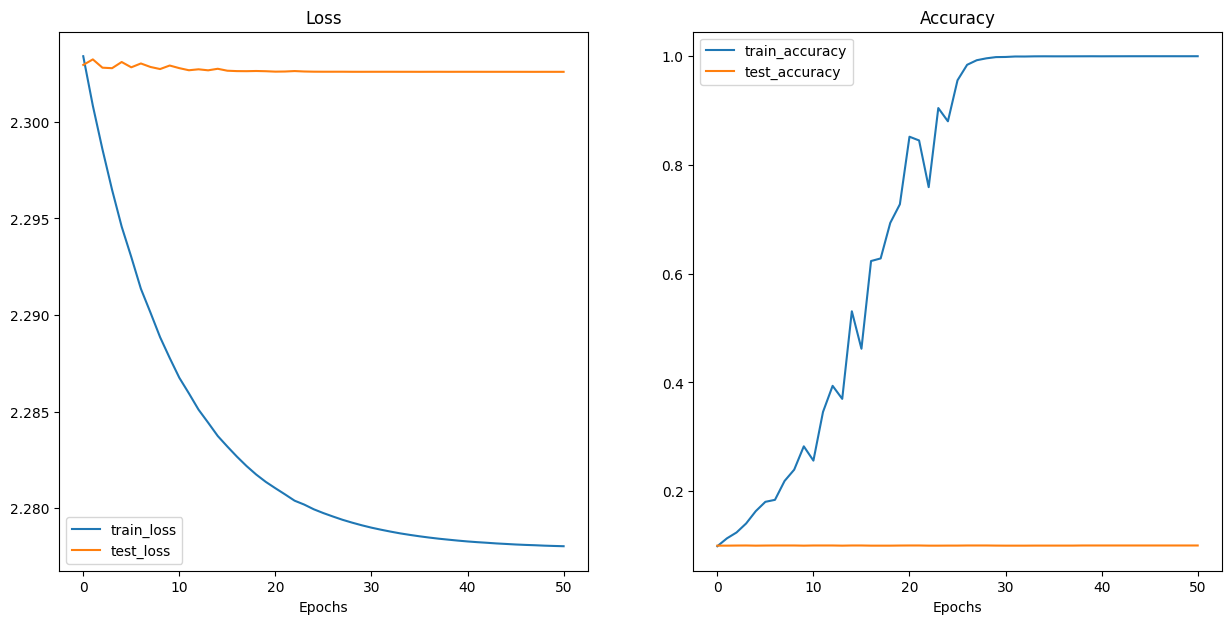

In [141]:
# Set the centers to be one for each sample in the training data
sample_centers = bulk_tensor_train_data

# Setup model with input parameters
RBF_clf = RBF(centers=sample_centers, # number of RBF neurons
    output_shape=len(class_names) # one for every class
).to(device)

# Setup optimizer
optimizer = torch.optim.SGD(params=RBF_clf.parameters(), lr=0.1)

# Setup accuracy function
mca = MulticlassAccuracy(num_classes=10, average='micro').to(device)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup scheduler
scheduler = ExponentialLR(optimizer, gamma=0.9)

# Set number of epochs
epochs = 51

test_train_plot(model=RBF_clf,
               data_loader_train=train_dataloader,
               data_loader_test=test_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=mca,
               epochs=epochs,
               scheduler=scheduler)

Predictably, we observe extreme overfitting: the training accuracy climbs all the way up to **~100%** while the actual testing accuracy remains at **chance odds** all throughout. The results would perhaps be less bad if we only had access to a small training dataset (thus resulting in relatively few centers), but it appears to be a terrible option for our case. The execution time has also increased **substantially** - overall, a failure.

As our last test regarding how we initialize the centers, we will use the method of K-Means clustering. We will create 10 clusters (one for every class) and thus 10 centers, each one placed on the mean of one of the clusters.

  2%|▏         | 1/51 [00:09<07:34,  9.08s/it]

Epoch: 0
---------
Train loss: 2.22725 | Train accuracy: 19.72%
Test loss: 2.17032 | Test accuracy: 23.48%



 22%|██▏       | 11/51 [01:37<05:56,  8.90s/it]

Epoch: 10
---------
Train loss: 2.03332 | Train accuracy: 26.24%
Test loss: 2.02548 | Test accuracy: 26.75%



 41%|████      | 21/51 [03:08<04:31,  9.07s/it]

Epoch: 20
---------
Train loss: 2.01047 | Train accuracy: 26.85%
Test loss: 2.00459 | Test accuracy: 27.34%



 61%|██████    | 31/51 [04:38<02:59,  8.99s/it]

Epoch: 30
---------
Train loss: 2.00378 | Train accuracy: 27.06%
Test loss: 1.99855 | Test accuracy: 27.55%



 80%|████████  | 41/51 [06:08<01:30,  9.03s/it]

Epoch: 40
---------
Train loss: 2.00159 | Train accuracy: 27.16%
Test loss: 1.99657 | Test accuracy: 27.67%



100%|██████████| 51/51 [07:37<00:00,  8.98s/it]

Epoch: 50
---------
Train loss: 2.00083 | Train accuracy: 27.16%
Test loss: 1.99589 | Test accuracy: 27.77%

Total training time: 457.957 seconds


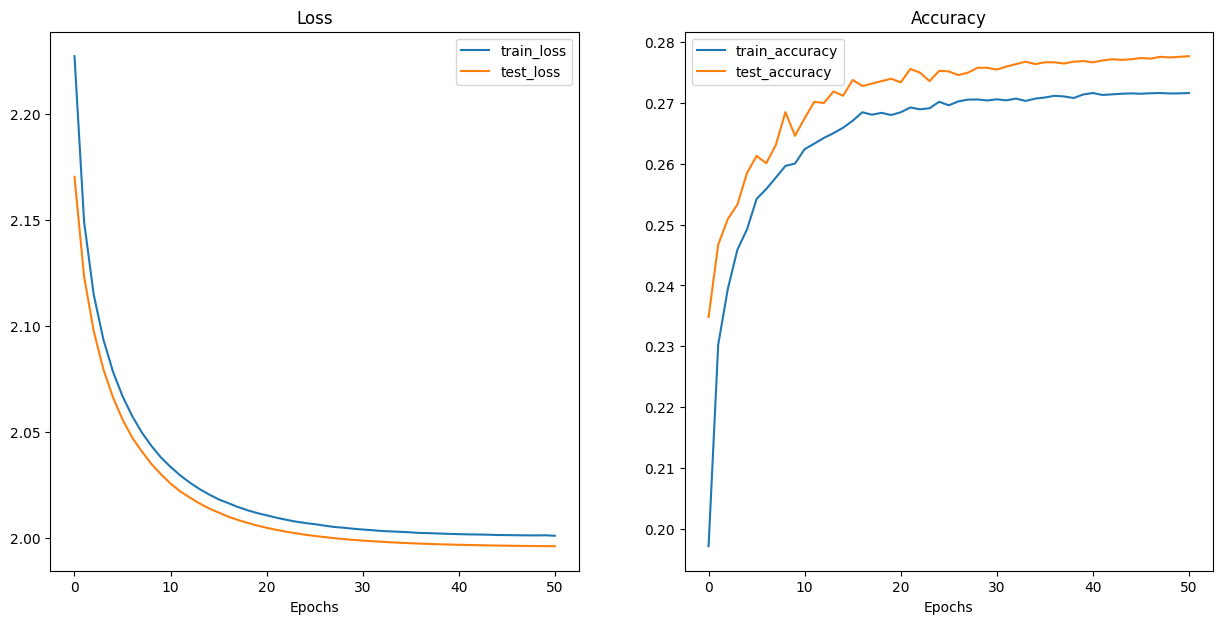

In [ ]:
# Sklearn provides a ready-made implementation of the KMeans algorithm
kmeans = KMeans(n_clusters=10)

# We just have to watch out for the fact that Sklearn uses numpy arrays and not torch tensors. For this reason we give it the data while moving it on the cpu and converting it to a numpy array.
kmeans.fit(bulk_tensor_train_data.cpu().numpy())

# We also have to convert its output to a PyTorch Tensor, if we are to use it with our model on the GPU
centers = torch.tensor(kmeans.cluster_centers_, device=device, dtype=torch.float32)

# Setup model with input parameters
RBF_clf = RBF(centers=centers, # number of RBF neurons
    output_shape=len(class_names) # one for every class
).to(device)

# Setup optimizer
optimizer = torch.optim.SGD(params=RBF_clf.parameters(), lr=0.1)

# Setup accuracy function
mca = MulticlassAccuracy(num_classes=10, average='micro').to(device)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup scheduler
scheduler = ExponentialLR(optimizer, gamma=0.9)

# Set number of epochs
epochs = 51

test_train_plot(model=RBF_clf,
               data_loader_train=train_dataloader,
               data_loader_test=test_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=mca,
               epochs=epochs,
               scheduler=scheduler)

Test accuracy has gone up to **~28%** and the model took significantly fewer epochs to converge. What's more, the loss and accuracy curves are finally closer to what we'd expect them to be (in relation to each other). On the accuracy side, the curves are also a lot smoother; we see much smaller fluctuations than we saw before.

Overall a great success. It seems that the method of initialization of the centers plays a huge role on how well the RBF network functions.

So far we have been working with the **sigma** parameter *not* set as a model parameter. It makes sense to examine whether changing that will help performance.

In [147]:
class RBF_2(nn.Module):
    def __init__(self, centers: torch.Tensor, output_shape: int):
        super().__init__()

        # The number of hidden units is equal to the number of centers
        self.hidden_units = centers.shape[0]

        # The centers are the main parameters of the model (what the model adjusts when it learns)
        self.centers = nn.Parameter(centers, requires_grad=True)

        # The sigma parameter is initially set to a value that in theory should work relatively well
        d = torch.cdist(centers, centers)
        # As for why we do this step, see https://github.com/pytorch/pytorch/issues/123082
        d.fill_diagonal_(0)
        sigma = torch.max(d) / ((2 * self.hidden_units)**0.5)

        # Time to set the sigma parameter as a learnable/adjustable model parameter
        self.sigma = nn.Parameter(torch.ones(self.hidden_units, device=device)*sigma, requires_grad=True)

        # The output layer is a simple linear layer
        self.output_layer = nn.Linear(in_features=self.hidden_units, out_features=output_shape)
    
    def forward(self, x):
        # Calculate the distance between the input and the centers
        flatten = nn.Flatten()
        dist = torch.cdist(flatten(x), self.centers)
        # Calculate the RBF function
        rbf = torch.exp(-dist**2 / (2 * self.sigma**2))
        # Calculate the output
        return  self.output_layer(rbf)

  2%|▏         | 1/51 [00:09<07:40,  9.21s/it]

Epoch: 0
---------
Train loss: 2.23960 | Train accuracy: 18.81%
Test loss: 2.18120 | Test accuracy: 22.13%



 22%|██▏       | 11/51 [01:39<06:03,  9.08s/it]

Epoch: 10
---------
Train loss: 1.99903 | Train accuracy: 27.24%
Test loss: 1.99095 | Test accuracy: 27.84%



 41%|████      | 21/51 [03:10<04:33,  9.10s/it]

Epoch: 20
---------
Train loss: 1.96693 | Train accuracy: 28.11%
Test loss: 1.96169 | Test accuracy: 28.54%



 61%|██████    | 31/51 [04:41<03:02,  9.14s/it]

Epoch: 30
---------
Train loss: 1.95745 | Train accuracy: 28.47%
Test loss: 1.95316 | Test accuracy: 28.84%



 80%|████████  | 41/51 [06:13<01:31,  9.11s/it]

Epoch: 40
---------
Train loss: 1.95444 | Train accuracy: 28.54%
Test loss: 1.95035 | Test accuracy: 28.98%



100%|██████████| 51/51 [07:43<00:00,  9.09s/it]

Epoch: 50
---------
Train loss: 1.95340 | Train accuracy: 28.57%
Test loss: 1.94939 | Test accuracy: 29.04%

Total training time: 463.835 seconds


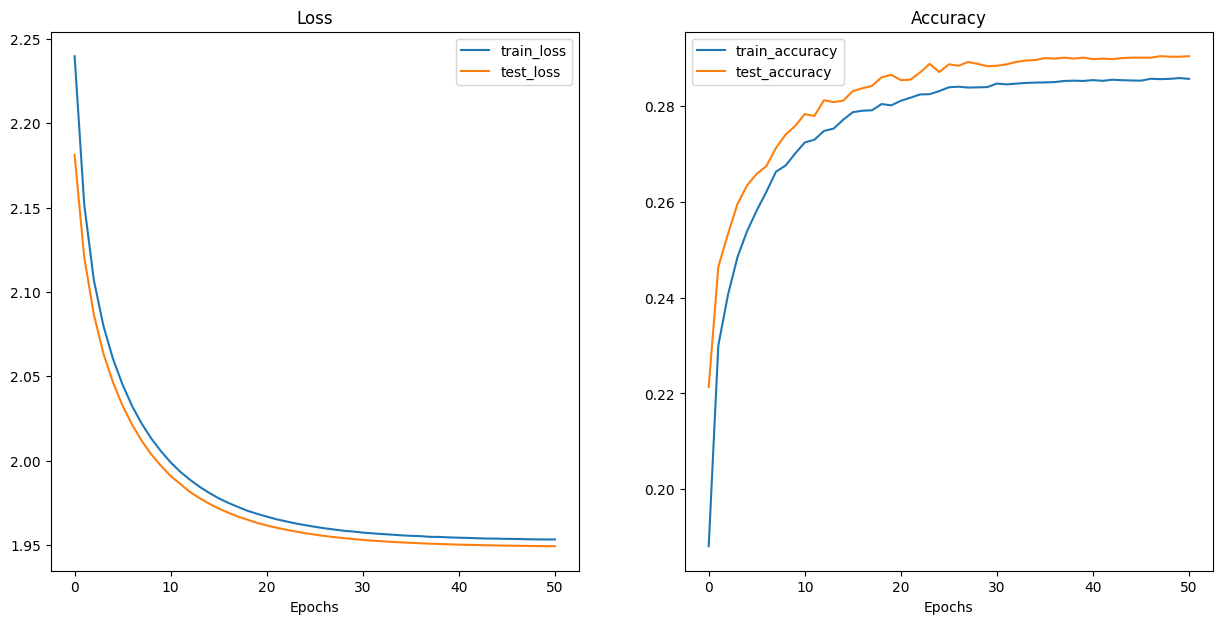

In [148]:
# Sklearn provides a ready-made implementation of the KMeans algorithm
kmeans = KMeans(n_clusters=10)

# We just have to watch out for the fact that Sklearn uses numpy arrays and not torch tensors. For this reason we give it the data while moving it on the cpu and converting it to a numpy array.
kmeans.fit(bulk_tensor_train_data.cpu().numpy())

# We also have to convert its output to a PyTorch Tensor, if we are to use it with our model on the GPU
centers = torch.tensor(kmeans.cluster_centers_, device=device, dtype=torch.float32)

# Setup model with input parameters
RBF_clf = RBF_2(centers=centers, # number of RBF neurons
    output_shape=len(class_names) # one for every class
).to(device)

# Setup optimizer
optimizer = torch.optim.SGD(params=RBF_clf.parameters(), lr=0.1)

# Setup accuracy function
mca = MulticlassAccuracy(num_classes=10, average='micro').to(device)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup scheduler
scheduler = ExponentialLR(optimizer, gamma=0.9)

# Set number of epochs
epochs = 51

test_train_plot(model=RBF_clf,
               data_loader_train=train_dataloader,
               data_loader_test=test_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=mca,
               epochs=epochs,
               scheduler=scheduler)

Test accuracy now ends up at **~29%**. Not a particularly significant increase, but it is an increase nonetheless. For this reason we will keep **sigma** a model parameter.

Now that we've figured out some basics, we should test the impact of **PCA** (Principal Component Analysis), as this is likely to drastically reduce runtime by reducing the dimensionality of our data. At the same time, we saw in the last assignment that it also has the potential to increase accuracy, so there is a lot to be gained by trying it.

To accomplish this we will use `torch_pca` (https://torch-pca.readthedocs.io/en/latest/index.html) in much the same way we did before. In order to find what explained variance threshold value we should use, we will test how the model performs in the range of **90-100%**.

Before we begin, we'll create a PyTorch `class` to use our PCA-data in the same way we use the normal CIFAR-10 data provided by PyTorch (ie with a `DataLoader`).

In [149]:
# Create new class into which we will put the PCA-transformed data, to then be fed into a dataloader
class PCACIFAR10Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

To help with readability, we will create a function that takes a dataset, applies PCA to it, creates **n** centers using K-Means clustering, and then returns both the centers and the dataset (in the form of a `DataLoader` object).

In [151]:
def PCA_KMeans(train_data, train_labels, test_data, test_labels, n_components, n_clusters, device):
    # Set up the PyTorch PCA object
    tPCA = torchPCA(n_components)

    # Apply PCA
    pca_train_data = tPCA.fit_transform(train_data)
    pca_test_data = tPCA.transform(test_data)

    # Set up the KMeans object and apply KMeans to the PCA-transformed data
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(pca_train_data.cpu().numpy())
    pca_centers = torch.tensor(kmeans.cluster_centers_, device=device, dtype=torch.float32)

    # Create dataset objects for the PCA data
    pca_train_dataset = PCACIFAR10Dataset(pca_train_data, train_labels)
    pca_test_dataset = PCACIFAR10Dataset(pca_test_data, test_labels)

    # Create dataloader objects for the dataset
    pca_train_loader = DataLoader(pca_train_dataset, # dataset to turn into iterable
        batch_size=BATCH_SIZE, # number of samples per batch
        shuffle=True # option to shuffle data every epoch
    )

    pca_test_loader = DataLoader(pca_test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False # don't necessarily have to shuffle the testing data
    )

    return pca_train_loader, pca_test_loader, pca_centers


Now it's time to conduct the test. The code is not very compact as the `test_train_plot()` function cannot be used as-is for what we are doing; parts of what it contains are therefore rewritten: namely, we take the training, testing and results-storing loop and place it inside another loop that iterates over a range of `p` values for the PCA transform to use. We apply that PCA transform, create the centers with K-Means and setup the model before entering the inner loop.

After the last epoch of each run, we append the final accuracy values to a list of their own such that by the end of the whole thing we have a list of values to plot in conjunction with the PCA `p` values. This will tell us what `p` value gives the best results (within the range we are searching).

We could make new functions for more than just the PCA & K-Means clustering portion, but we will not be reusing them so it would actually be a waste of space.

Total runtime: 1447.768 seconds
The test accuracy is maximized for threshold equal to 93%.


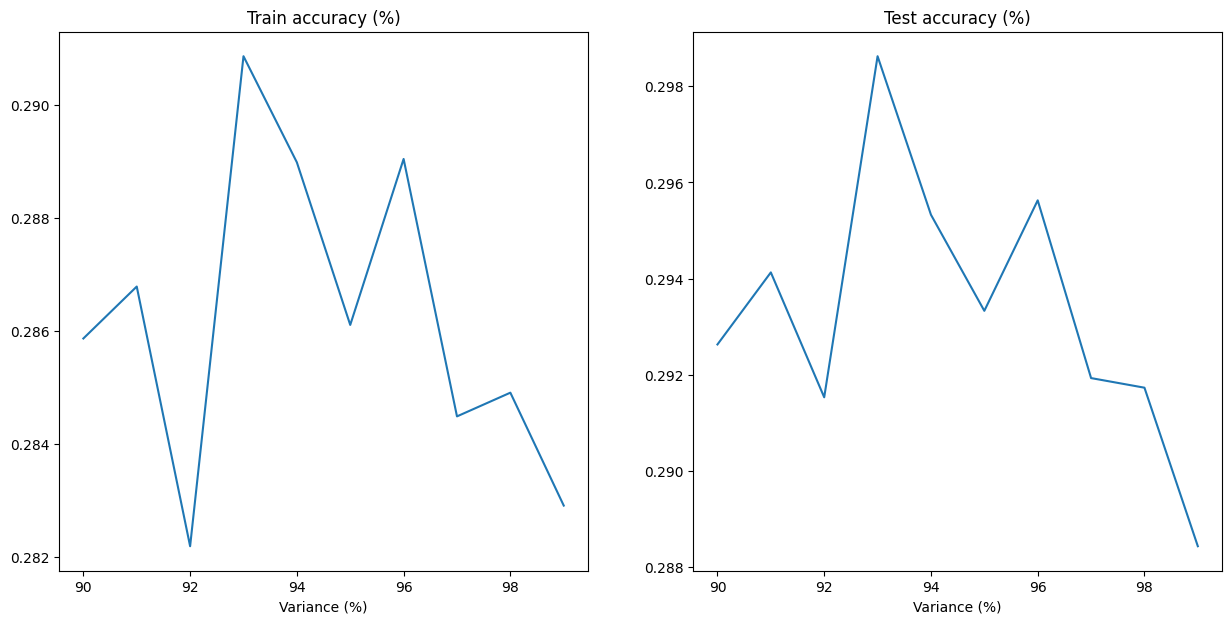

In [175]:
# Prepare lists for the train/test accuracy values; we'll get a set of 10 (one for each PCA component number we'll try) and we want to plot them and find the max
train_accuracy_values = []
test_accuracy_values = []

# Start the timer
start_time = timer()

# Iterate over the component number range
for p in range(90, 100):

    # Create a results dictionary to store the metrics
    results = {"train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []
        }
    
    # Apply PCA
    pca_train_loader, pca_test_loader, pca_centers = PCA_KMeans(bulk_tensor_train_data,
                                                                bulk_tensor_train_labels, 
                                                                bulk_tensor_test_data, 
                                                                bulk_tensor_test_labels, 
                                                                p/100, 10, device)
    
    # Setup model with input parameters
    RBF_clf = RBF_2(centers=pca_centers, # number of RBF neurons
        output_shape=len(class_names) # one for every class
    ).to(device)

    # Setup optimizer
    optimizer = torch.optim.SGD(RBF_clf.parameters(), lr=0.1)

    # Setup accuracy function
    mca = MulticlassAccuracy(num_classes=10, average='micro').to(device)

    # Setup loss function
    loss_fn = nn.CrossEntropyLoss()

    # Setup scheduler
    scheduler = ExponentialLR(optimizer, gamma=0.9)

    # Set number of epochs
    epochs = 51

    for epoch in range(epochs):
        # Training step
        train_loss, train_acc = train_step(data_loader=pca_train_loader, 
            model=RBF_clf, 
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=mca,
            scheduler=scheduler
        )
        
        #Testing step
        test_loss, test_acc = test_step(data_loader=pca_test_loader,
            model=RBF_clf,
            loss_fn=loss_fn,
            accuracy_fn=mca,
        )
    
        # Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage and plotting
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)
    
    # Append the final accuracy values to the lists
    train_accuracy_values.append(results["train_acc"][-1])
    test_accuracy_values.append(results["test_acc"][-1])

# End the timer and print out how long it took
end_time = timer()

print(f"Total runtime: {end_time-start_time:.3f} seconds")

p_range = list(range(90, 100))

# Setup a plot 
plt.figure(figsize=(15, 7))

# Plot train accuracy
plt.subplot(1, 2, 1)
plt.plot(p_range, train_accuracy_values)
plt.title('Train accuracy (%)')
plt.xlabel('Variance (%)')

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(p_range, test_accuracy_values)
plt.title('Test accuracy (%)')
plt.xlabel('Variance (%)')

# Find the index of the maximum test accuracy value, in order to find the corresponding best component number
max_pca_test_accuracy_index = test_accuracy_values.index(max(test_accuracy_values))

best_threshold = p_range[max_pca_test_accuracy_index]

print(f"The test accuracy is maximized for threshold equal to {best_threshold}%.")



The value we got is `0.93`. Unlike the previous assignment, this time *both* the training and testing accuracy have wild fluctuations, and the maximization of the testing accuracy appears to line up with that of the training one.

Having found the best value to use in the PCA transform, let's have a more detailed look at how the model performs using it.

  2%|▏         | 1/51 [00:02<02:10,  2.60s/it]

Epoch: 0
---------
Train loss: 2.21765 | Train accuracy: 19.81%
Test loss: 2.15932 | Test accuracy: 21.14%



 22%|██▏       | 11/51 [00:29<01:45,  2.65s/it]

Epoch: 10
---------
Train loss: 1.98686 | Train accuracy: 27.33%
Test loss: 1.98008 | Test accuracy: 28.32%



 41%|████      | 21/51 [00:55<01:20,  2.67s/it]

Epoch: 20
---------
Train loss: 1.95722 | Train accuracy: 28.34%
Test loss: 1.95283 | Test accuracy: 29.12%



 61%|██████    | 31/51 [01:22<00:53,  2.67s/it]

Epoch: 30
---------
Train loss: 1.94840 | Train accuracy: 28.50%
Test loss: 1.94489 | Test accuracy: 29.45%



 80%|████████  | 41/51 [01:49<00:26,  2.69s/it]

Epoch: 40
---------
Train loss: 1.94565 | Train accuracy: 28.58%
Test loss: 1.94228 | Test accuracy: 29.70%



100%|██████████| 51/51 [02:16<00:00,  2.68s/it]

Epoch: 50
---------
Train loss: 1.94460 | Train accuracy: 28.65%
Test loss: 1.94139 | Test accuracy: 29.77%

Total training time: 136.560 seconds


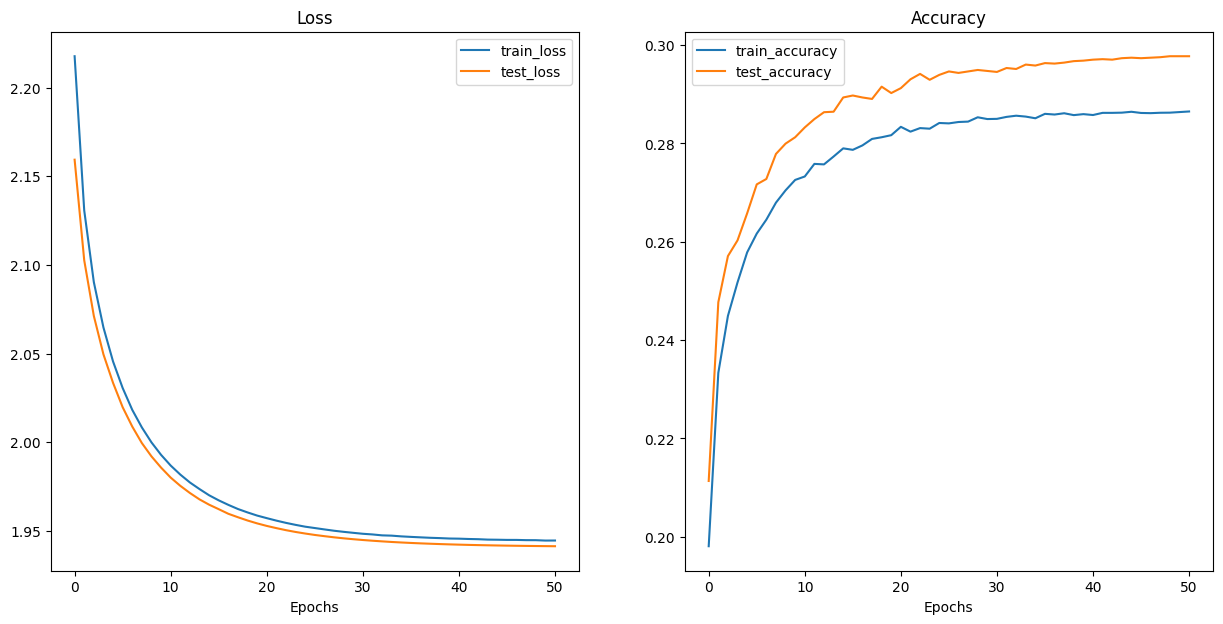

In [176]:
pca_train_loader, pca_test_loader, pca_centers = PCA_KMeans(bulk_tensor_train_data,
                                                                bulk_tensor_train_labels, 
                                                                bulk_tensor_test_data, 
                                                                bulk_tensor_test_labels, 
                                                                0.93, 10, device)

# Setup model with input parameters
RBF_clf = RBF_2(centers=pca_centers, # number of RBF neurons
    output_shape=len(class_names) # one for every class
).to(device)

# Setup optimizer
optimizer = torch.optim.SGD(params=RBF_clf.parameters(), lr=0.1)

# Setup accuracy function
mca = MulticlassAccuracy(num_classes=10, average='micro').to(device)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup scheduler
scheduler = ExponentialLR(optimizer, gamma=0.9)

# Set number of epochs
epochs = 51

test_train_plot(model=RBF_clf,
               data_loader_train=pca_train_loader,
               data_loader_test=pca_test_loader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=mca,
               epochs=epochs,
               scheduler=scheduler)

There is some improvement in test accuracy, but it is very minimal - less than **1%**. There is also noticeably increased overfitting. As expected, the runtime is drastically decreased.

Before calling it quits and evaluating the model's performance, we will switch to a different optimizer and see if that makes a difference.

Specifically, we are switching from `SGD` (Stochastic Gradient Descent) to `Adam`.

  2%|▏         | 1/51 [00:02<02:25,  2.91s/it]

Epoch: 0
---------
Train loss: 1.87601 | Train accuracy: 31.25%
Test loss: 1.78684 | Test accuracy: 35.49%



 22%|██▏       | 11/51 [00:31<01:54,  2.87s/it]

Epoch: 10
---------
Train loss: 1.69386 | Train accuracy: 38.76%
Test loss: 1.67429 | Test accuracy: 39.43%



 41%|████      | 21/51 [01:00<01:27,  2.90s/it]

Epoch: 20
---------
Train loss: 1.65513 | Train accuracy: 40.64%
Test loss: 1.63924 | Test accuracy: 41.18%



 61%|██████    | 31/51 [01:30<00:58,  2.92s/it]

Epoch: 30
---------
Train loss: 1.63908 | Train accuracy: 41.41%
Test loss: 1.63229 | Test accuracy: 41.67%



 80%|████████  | 41/51 [01:59<00:29,  2.92s/it]

Epoch: 40
---------
Train loss: 1.63204 | Train accuracy: 41.74%
Test loss: 1.62861 | Test accuracy: 41.65%



100%|██████████| 51/51 [02:28<00:00,  2.91s/it]

Epoch: 50
---------
Train loss: 1.62939 | Train accuracy: 41.77%
Test loss: 1.62795 | Test accuracy: 41.81%

Total training time: 148.421 seconds


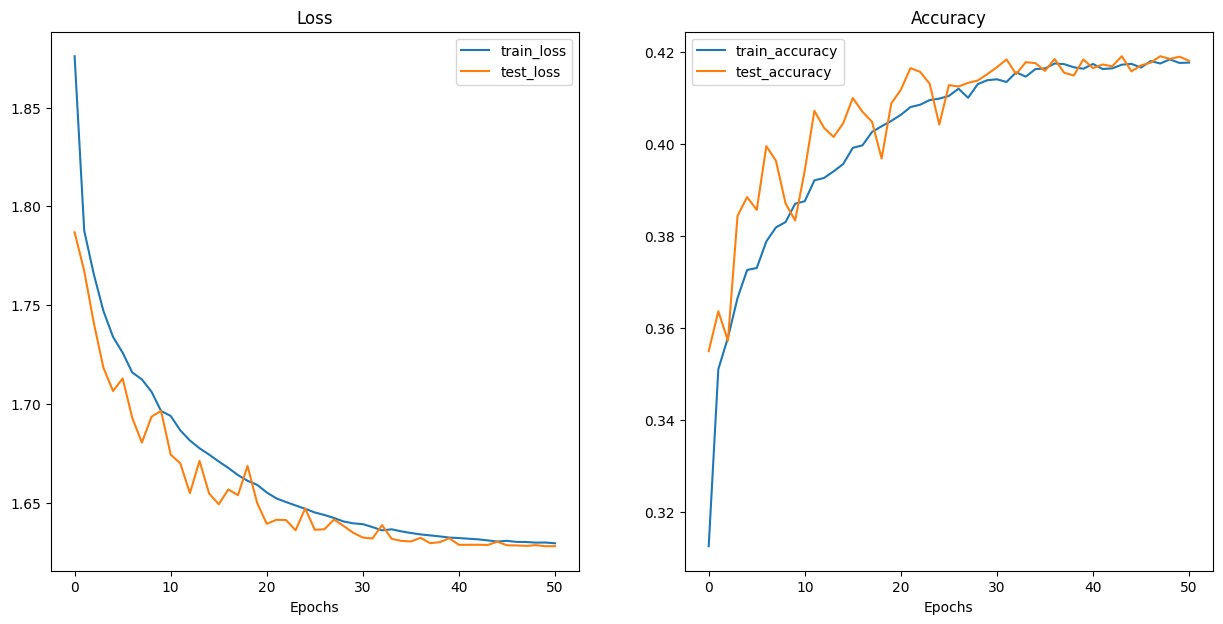

In [179]:
pca_train_loader, pca_test_loader, pca_centers = PCA_KMeans(bulk_tensor_train_data,
                                                                bulk_tensor_train_labels, 
                                                                bulk_tensor_test_data, 
                                                                bulk_tensor_test_labels, 
                                                                0.93, 10, device)

# Setup model with input parameters
RBF_clf = RBF_2(centers=pca_centers, # number of RBF neurons
    output_shape=len(class_names) # one for every class
).to(device)

# Setup optimizer
optimizer = torch.optim.Adam(params=RBF_clf.parameters(), lr=0.1)

# Setup accuracy function
mca = MulticlassAccuracy(num_classes=10, average='micro').to(device)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup scheduler
scheduler = ExponentialLR(optimizer, gamma=0.9)

# Set number of epochs
epochs = 51

test_train_plot(model=RBF_clf,
               data_loader_train=pca_train_loader,
               data_loader_test=pca_test_loader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=mca,
               epochs=epochs,
               scheduler=scheduler)

Finally we have managed to achieve a substantial increase in performance. From a test accuracy of ~30% we have jumped to **~42%** - an increase of ~12%.

It seems that while the previous classifiers we tested did fine using `SGD`, the **RBF** classifier is more suited to a more sophisticated optimizer like `Adam`.

As always, we should look at some examples of correct and incorrect classification. We repeat the same method we used in the other assignments.

**Prediction function**

In [180]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

**Sample creation, prediction and visualization**

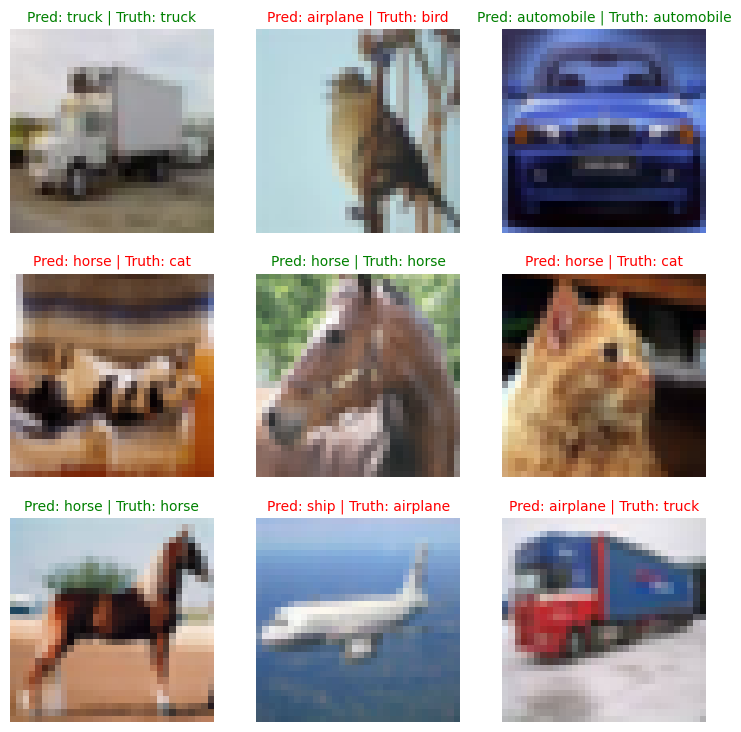

In [187]:
# Need to store the samples
test_samples = []
test_labels = []

# Set random seed for reproducibility
random.seed(42)

# Pick samples at random from the dataset
for sample, label in random.sample(list(tensor_test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# Set up the PyTorch PCA object
tPCA = torchPCA(0.93)

# Apply PCA
pca_tensor_train_data = tPCA.fit_transform(bulk_tensor_train_data)
# test_samples is a list, so we need to stack it to turn it into a tensor. also, we reshape it (flatten it) via the view method to apply PCA
pca_sample_data = tPCA.transform(torch.stack(test_samples).view(9, -1))

# Get the prediction probabilities and classes while applying PCA
pred_probs= make_predictions(model=RBF_clf, 
                             data=pca_sample_data)
pred_classes = pred_probs.argmax(dim=1)

# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.permute(1,2,0))

  # Find the prediction label (in text form)
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form)
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

The mistakes it makes are in general not as confusing as the ones made by the SVM in the previous assignment.

The dataset contains some planes that have a triangular-type shape. This can explain the bird-plane mistake, especially since the background is all light blue, like the sky is in the pictures of airplanes.

Twice cats are mistaken for horses. In the first instance, it is somewhat understandable, as the image is in general very unclear/confusing, but in the second instance the cat really shouldn't have been misidentified. Perhaps the way its head is positioned makes it difficult for the RBF to tell whether it is small, like a cat's, or bigger, like a horse's.

The plane being misclassified as a ship is excusable in the sense that there are a lot of white/light-colored ships in the dataset, and the background is darkish blue, like the ocean. Still the shape of the object *should* identify it as a plane.

Finally, the truck being classed as an airplane is the most peculiar of the bunch; it really doesn't make much sense apart from the light background (like clouds in the sky).

### **Conclusion**

The **RBF** network's performance is better than that offered by the 1-NN, 3-NN and NC classifiers, however it fails to outperform the MLPs and falls far behind the SVM and CNN models. As a positive, it exhibits lower computational demand, since the training time is **~80** seconds lower than the fastest MLP we evaluated and **~58** seconds lower than the SVM.

Specifically, the performance numbers are as follows:

-   CNN --- **66.54%** accuracy after **394.153** seconds
-   SVM --- **56.71%** accuracy after **206.95** seconds

- ComplexMLP --- **47.28%** accuracy after **252.500** seconds
- SimpleMLP --- **45.44%** accuracy after **231.418** seconds

- RBF --- **41.81%** accuracy after **148.421** seconds

- 1-NN --- **36.34%**
- 3-NN --- **33.81%**
- NC ---**27.75%**


**Resources and tools used:**

**ROCm**

https://gist.githubusercontent.com/damico/484f7b0a148a0c5f707054cf9c0a0533/raw/43c317bfbde626d9112d44462d815613194988e0/test-rocm.py

https://rocm.docs.amd.com/projects/install-on-linux/en/develop/install/3rd-party/pytorch-install.html

https://rocm.docs.amd.com/projects/install-on-linux/en/latest/install/native-install/ubuntu.html


**PyTorch**

https://pytorch.org/

https://www.dataquest.io/blog/pytorch-for-beginners/

**PCA for PyTorch**

https://github.com/valentingol/torch_pca

https://torch-pca.readthedocs.io/en/latest/

**Useful 'PrintLayer' for debugging PyTorch models**

https://discuss.pytorch.org/t/how-do-i-print-output-of-each-layer-in-sequential/5773/3


**Scikit-Learn**

https://scikit-learn.org/stable/index.html


**The CIFAR-10 image database**

https://www.cs.toronto.edu/~kriz/cifar.html

Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.
(https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf)


**VSCode**

https://code.visualstudio.com/

GitHub Copilot was utilized for error correction/debugging and autocomplete.